# Предсказание температуры расплавленной стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

**Описание этапа обработки**

Расплавленную сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Подогрев стали до нужной температуры производится с помощью графитовых электродов. Из сплава выводится сера. Подавая куски сплава из бункера для сыпучих материалов и проволоку через специальный трайб-аппарат аппарат корректируется химический состав стали и отбираются пробы.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Затем температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки. Далее сталь отправляют на доводку металла или поступает в машину непрерывной разливки.

**Задача проекта**

Уменьшения потребления электроэнергии можно добиться достижением одинаковой оптимальной температуры расплавленной стали. Это позволит оптимизировать процесс нагрева сплава и в будущем увеличить срок службы металлических ковшей, кирпичная облицовка которых разрушается от резких перепадов температур.

**Задача проекта** заключается в построении модели, которая по исходным данным будет предсказывать конечную температуру расплавленной стали с точностью *MAE* < **6.8**.

Проект будет проходить в несколько **этапов**:
<p><b>1</b> Обзор данных
<p><b>2</b> Исследовательский анализ данных
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>2.1</b> Данные об измерениях температуры
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>2.2</b> Данные о работе электродов
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>2.3</b> Данные об объеме пропущенного газа
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>2.4</b> Данные об объеме сыпучих материалов
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>2.5</b> Данные об объеме проволочных материалов
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>2.6</b> Выводы
<p><b>3</b> Разделение на <i>обучающую</i> и <i>тестовую выборки</i>
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>3.1</b> Создание таблиц с признаками
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>3.2</b> Проверка признаков на коллинеарность
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>3.3</b> Разделение данных на выборки. Стандартизация признаков.
<p><b>4</b> Построение и обучение моделей
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>4.1</b>  <i>Гребневая регрессия</i>
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>4.2</b>  <i>Cлучайный лес</i>
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>4.3</b>  <i>Градиентный бустинг</i>
<p><b>5</b> Выбор и тестирование лучшей модели
<p>&nbsp;&nbsp;&nbsp;&nbsp; <b>5.1</b> Сравнение моделей
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>5.2</b> Тестирование лучшей модели
<br>&nbsp;&nbsp;&nbsp;&nbsp; <b>5.3</b> Выявление значимости признаков
<p><b>6</b> Выводы

## Обзор данных

Импортируем необходимые для дальнейшей работы библиотеки, прочитаем и сохраним данные в виде отдельных таблиц.

In [1]:
# установка библиотеки shap
!pip install shap

In [2]:
# импорт билиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor

import shap

In [3]:
# чтение файлов с данными и их сохранение
datum = {}
try:
    datum['data_arc'] = pd.read_csv('data_arc.csv')
    datum['data_bulk'] = pd.read_csv('data_bulk.csv')
    datum['data_bulk_time'] = pd.read_csv('data_bulk_time.csv')
    datum['data_gas'] = pd.read_csv('data_gas.csv')
    datum['data_temp'] = pd.read_csv('data_temp.csv')
    datum['data_wire'] = pd.read_csv('data_wire.csv')
    datum['data_wire_time'] = pd.read_csv('data_wire_time.csv')
except:
    datum['data_arc'] = pd.read_csv('/datasets/final_steel/data_arc.csv')
    datum['data_bulk'] = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    datum['data_bulk_time'] = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    datum['data_gas'] = pd.read_csv('/datasets/final_steel/data_gas.csv')
    datum['data_temp'] = pd.read_csv('/datasets/final_steel/data_temp.csv')
    datum['data_wire'] = pd.read_csv('/datasets/final_steel/data_wire.csv')
    datum['data_wire_time'] = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

Согласно документации данные содержат следующую информацию:

* `datum['data_arc']` — данные об электродах
* `datum['data_bulk']` — данные о подаче сыпучих материалов (объём)
* `datum['data_bulk_time']` — данные о подаче сыпучих материалов (время)
* `datum['data_gas']` — данные о продувке сплава газом
* `datum['data_temp']` — результаты измерения температуры
* `datum['data_wire']` — данные о проволочных материалах (объём)
* `datum['data_wire_time']` — данные о проволочных материалах (время)

Столбец `key` в таблицах — это номер партии.

Посмотрим на данные, выведем первые 10 строк каждой таблицы.

In [4]:
# вывод первых 10 строк таблиц
for data in datum:
    print(f'datum[{data}]')
    display(datum[data].head(10))

datum[data_arc]


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


datum[data_bulk]


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


datum[data_bulk_time]


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


datum[data_gas]


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


datum[data_temp]


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


datum[data_wire]


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


datum[data_wire_time]


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Мы видим, что помимо номера партии таблица:

* `datum['data_arc']` содержит время начала и время конца нагрева, а также активную и реакутивную состовляющие полной мощности. Отметим, что количество включений дуги для каждой партии не обязатльно одинаковое. Так для партии 1 было произведено 5 нагревов, для партии 2 — 4
* `datum['data_bulk']` содержит количество сыпучих материалов, добавленных в расплавленную сталь из разных бункеров
* `datum['data_bulk_time']` содержит времена подачи сыпучих материалов
* `datum['data_gas']` содержит количество инертного газа, пропущенного через расплавленную сталь
* `datum['data_temp']` содержит температуру расплавленной стали и время ее замера. Как и в случае с таблицей `datum['data_arc']`, количество замеров температры для каждой партии может быть разным
* `datum['data_wire']` содержит количество различных типов проволочных материалов, добавленных в расплавленную сталь
* `datum['data_wire_time']` содержит времена подачи проволочных материалов

Какие из этих признаков первичны, а какие вторичны разберем позже. Пока что только отметим, что *целевой признак* содержится в таблице `datum['data_temp']`. *Целевой признак* — это последняя замеренная температура для каждой отдельной партии.

Выведем общую информацию для каждой из таблиц.

In [5]:
# вывод общей информации о таблицах
for data in datum:
    print(f'datum[{data}]')
    display(datum[data].info())

datum[data_arc]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

datum[data_bulk]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

datum[data_bulk_time]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

datum[data_gas]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

datum[data_temp]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

datum[data_wire]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

datum[data_wire_time]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

Первое, на что обратим внимание, это то, что в таблицах разное количество строк. Как мы отметили выше, в таблицах `datum['data_arc']` и `datum['data_temp']` для одной и той же партии может быть произведено несколько нагревов и замеров температур. Поэтому в этих таблицах намного больше строк, чем в остальных, — 14876 и 15907 строк соответственно. В остальных таблицах порядка 3000 строк, их точное количество меняется от таблицы к таблице. Это значит, что есть партии, которые представлены не во всех таблицах. Нам стоит ориентироваться на то, что для обучения и тестирования моделей у нас будет не больше **3000 объктов** — столько же, сколько и партий.

Второй момент на который мы обратим внимание, это то, что в данных много пропусков. В данных, связанных с сыпучими и проволочными материалами пропуски означают, что добавление в сплав данного типа материала не производилось, а значит их можно заменить нулями. В данных с информацией о нагревах и замерах температур, пропуски нужно будет заменить либо какими-то статистическими показателями, либо удалить данные объекты из выборки.

Дальнейший анализ будет заключаться в исследовании распределений и выборосов численных характеристик процессов.

## Исследовательский анализ данных

### Данные об измерениях температуры

Исследовательский анализ начнем с таблицы `datum['data_temp']`, где, как мы отметили выше, хранится *целевой признак*. Сразу отметим, что начальная температура сплава может быть очень важным признаком, поэтому выделим его из данной таблицы вместе с *целевым*. Выведем количество пропусков в каждом из признаков.

In [6]:
# выделение начальной и конечной темпертур сплава
first_temp = datum['data_temp'].groupby('key').head(1)
last_temp = datum['data_temp'].groupby('key').tail(1)
del datum['data_temp']

In [7]:
# подсчет доли пропусков в таблице с начальной температурой
first_temp.isna().mean()

key             0.0
Время замера    0.0
Температура     0.0
dtype: float64

In [8]:
# подсчет доли пропусков в таблице с конечной температурой
last_temp.isna().mean()

key             0.000000
Время замера    0.000000
Температура     0.229789
dtype: float64

Мы видим, что для каждой партии существует начальная температура, а конечная отсутствует в **23%** случаев. Так как конечная темпераутура является *целевым признаком*, данные партии придется удалить из рассмотрения. Объединим обе таблицы.

In [9]:
# удаление пропусков из таблицы last_temp
last_temp = last_temp.dropna()

In [10]:
# объединение таблиц
data_temp = last_temp.merge(first_temp, on='key')
data_temp.columns = ['key', 'last_measuring_time', 'last_measuring_temp', 'first_measuring_time', 'first_measuring_temp']
origin_size = data_temp.shape[0]
del first_temp, last_temp

Рассмотрим распределения начальной и конечной температур. Напишем специальную функцию для визуализаций распределений признаков.

In [11]:
# создание функции визуализации распределений
def draw_distribution(data, col, title, left_border=0, right_border=1):
    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(15, 6))
    sns.histplot(data=data, x=col, ax=axs[0])
    axs[0].grid()
    axs[0].set_xlim(data[col].quantile(left_border), data[col].quantile(right_border))
    sns.boxplot(data=data, y=col, ax=axs[1])
    axs[1].grid()
    fig.suptitle(f'Частотное раcпределение и диаграмма размаха признака \'{title}\'', fontsize='x-large')

Выведем последовательно графики для начальной и конечной температур сплава.

count    2477.000000
mean     1588.405733
std        29.232904
min      1191.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: first_measuring_temp, dtype: float64

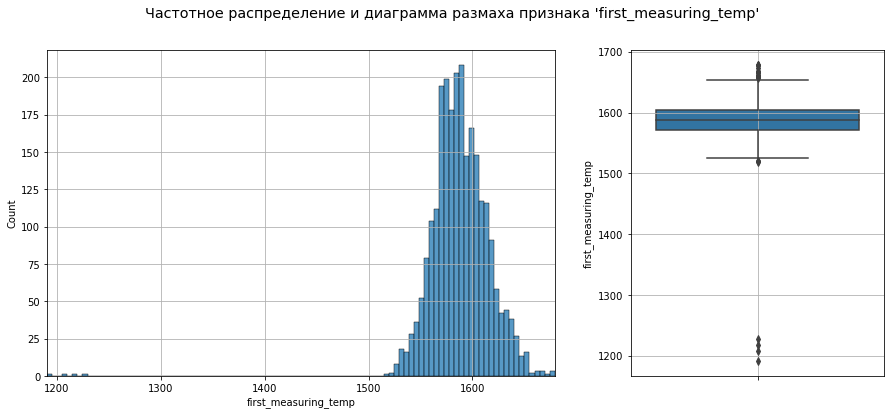

In [12]:
# визуализация распределения начальной температуры сплава 
draw_distribution(data_temp, 'first_measuring_temp', 'first_measuring_temp')
data_temp['first_measuring_temp'].describe()

count    2477.000000
mean     1595.334275
std        16.019339
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: last_measuring_temp, dtype: float64

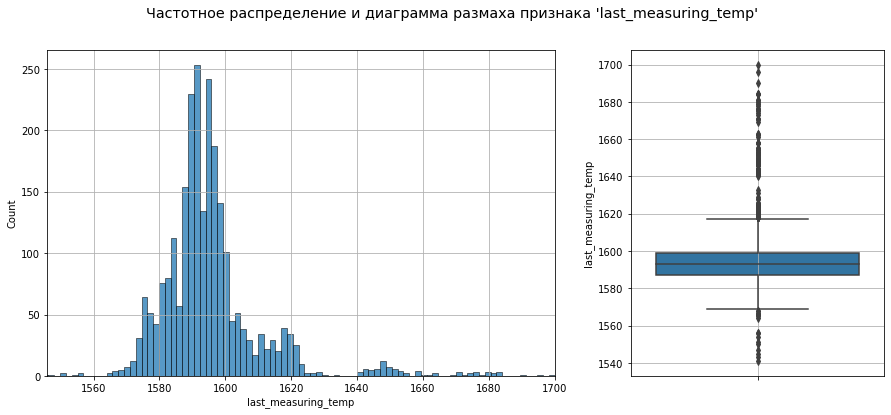

In [13]:
# визуализация распределения конечной температуры сплава
draw_distribution(data_temp, 'last_measuring_temp', 'last_measuring_temp', 0.001)
data_temp['last_measuring_temp'].describe()

Мы видим, что в обоих случаях распределения близки к **нормальному**. В случае с начальной температурой существует небольшая группа выборосов вблизи 1200 градусов. Учитывая, что температура плавления стали находится в пределах от 1300 до 1500 градусов, эти выборсы кажутся ошибкой измерения или ошибкой технологического процесса. По 25%-му и 75%-му квартелям можно сделать вывод, что начальная температура имеет менее плотное распределение, чем конечная. В первом случае — межквартильный размах находится в пределах от 1572 до 1606, во втором — от 1587 до 1599 градусов. Однако выбросы коненчной температуры распределены в более широких пределах, чем выбросы начальной температуры. Медианные значения температур отличаются всего на 5 градусов, для начальной — это 1588, для конечной — 1593.

Удалим группу выбросов начальной температуры менее **1300 градусов**.

In [14]:
# удаление выбросов начальной температуры
data_temp = data_temp[data_temp['first_measuring_temp'] > 1300]

Еще одним важным признаком, который содержит таблица `datum[data_temp]`, может оказаться промежуток времени между первым и последним замерами температур. Несмотря на то, что в будущем данный признак может сильно коррелировать с работой затраченной на нагрев сплава, мы посмотрим на  его распределение. Для этого приведем столбцы со временем к типу `datetime` и создадим новый признак `interval_between_measuring`.

In [15]:
# приведение столбцов со временем к соответствующему типу
data_temp['first_measuring_time'] = pd.to_datetime(data_temp['first_measuring_time'], format='%Y-%m-%d %H:%M:%S')
data_temp['last_measuring_time'] = pd.to_datetime(data_temp['last_measuring_time'], format='%Y-%m-%d %H:%M:%S')

In [16]:
# создание нового признака
data_temp['interval_between_measuring'] = ((data_temp['last_measuring_time'] -
                                            data_temp['first_measuring_time']).dt.seconds / 60).astype('float')

In [17]:
# удаление неинформативных столбцов
data_temp = data_temp.drop(columns=['last_measuring_time', 'first_measuring_time'])

Выведем распределение нового признака.

count    2473.000000
mean       30.888550
std        21.710782
min         0.000000
25%        19.683333
50%        26.500000
75%        37.700000
max       392.283333
Name: interval_between_measuring, dtype: float64

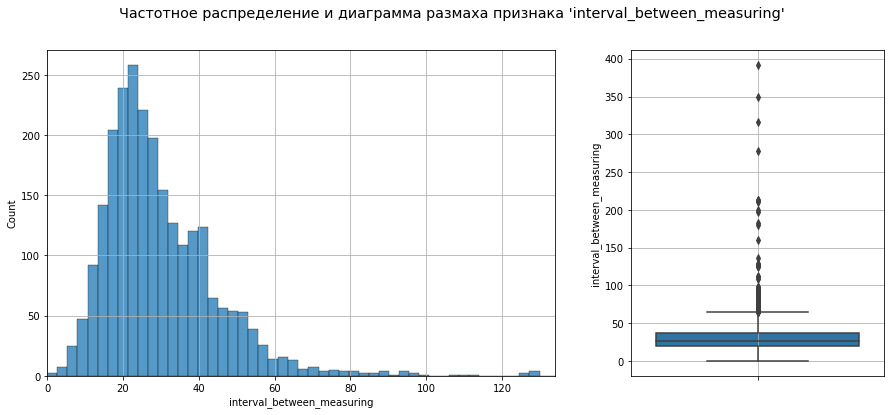

In [18]:
# визуализация распределения промежутка времени между замерами
draw_distribution(data_temp, 'interval_between_measuring', 'interval_between_measuring', right_border=0.995)
data_temp['interval_between_measuring'].describe()

Как мы видим, промежуток времени между замерами также имеет **нормальное** распределения. Межквартильный размах находится в пределах от 19 до 37 минут. Медианное значение равно 27 минутам. Существует небольшое количество выбросов. Согласно данным некоторые этапы обработки длились более 5-6 часов. Так как это не является физически невозможным, чтобы не сужать диапазон работы будущей модели, оставим данные о промежутках времени между замерами без изменений.

### Данные о работе электродов

Перейдем к таблице `datum['data_arc']`, хранящей в себе информацию о работе электродов. Данная таблица похожа по своей стуркутре на таблицу `datum['data_temp']`. Для каждой партии содержатся данные о конкретных итерациях нагрева. С физической точки зрения имеет смысл рассматривать признак, который бы представлял собой работу, затраченную на нагрев сплава. Для этого посчитаем промежутки времени, относящиеся к конкретной итерации нагрева.

In [19]:
# копирование таблицы
data_arc = datum['data_arc']
data_arc.columns = ['key', 'start_of_heating', 'end_of_heating', 'active_power', 'reactive_power']
del datum['data_arc']

In [20]:
# приведение столбцов со временем к соответствующему типу
data_arc['start_of_heating'] = pd.to_datetime(data_arc['start_of_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc['end_of_heating'] = pd.to_datetime(data_arc['end_of_heating'], format='%Y-%m-%d %H:%M:%S')

In [21]:
# создание нового признака
data_arc['interval_between_heating'] = ((data_arc['end_of_heating'] -
                                         data_arc['start_of_heating']).dt.seconds / 60).astype('float')

Посчитаем работу затраченную на нагрев сплава из каждой партии. Хотя с физической точки зрения на нагрев тратится именно активная составляющая мощности, посчитаем также и реактивную работу. Данный признак может быть полезен при обучении модели.

In [22]:
# создание новых признков
data_arc['active_work'] = data_arc['active_power'] * data_arc['interval_between_heating']
data_arc['reactive_work'] = data_arc['reactive_power'] * data_arc['interval_between_heating']

In [23]:
# удаление неинформативных столбцов
data_arc = data_arc.drop(columns=['start_of_heating', 'end_of_heating', 'active_power', 'reactive_power', 'interval_between_heating'])

In [24]:
# создание итоговой таблицы
data_arc = data_arc.groupby('key').sum().reset_index()

Выведем распределения активной и реактивной работ.

count    3214.000000
mean       11.889978
std         8.597634
min         0.176914
25%         5.910010
50%        10.098918
75%        15.459755
max       143.740723
Name: active_work, dtype: float64

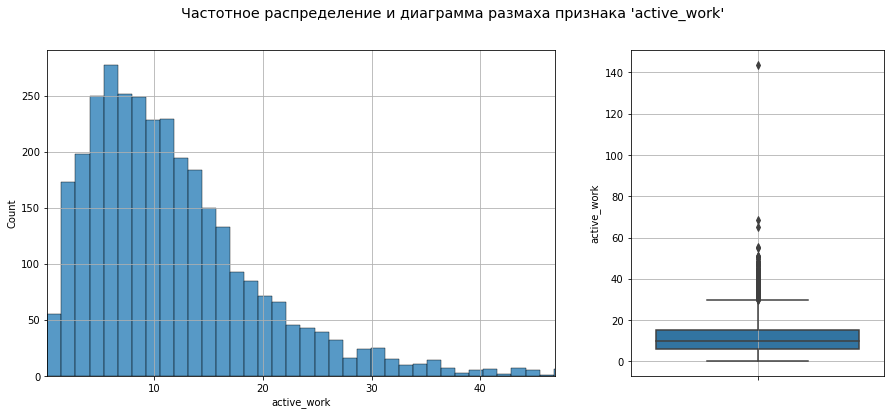

In [25]:
# визуализация распределения активной работы
draw_distribution(data_arc, 'active_work', 'active_work', right_border=0.995)
data_arc['active_work'].describe()

count    3214.000000
mean        8.513144
std        23.933657
min     -1298.070680
25%         4.469840
50%         7.561017
75%        11.572622
max       103.504287
Name: reactive_work, dtype: float64

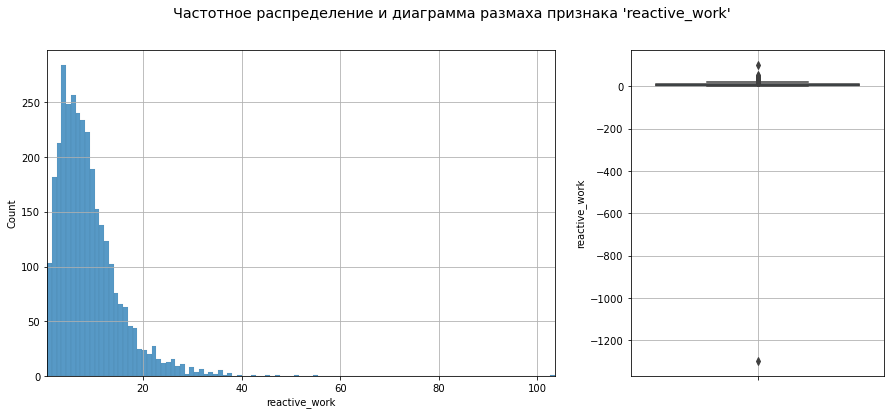

In [26]:
# визуализация распределения реактивной работы
draw_distribution(data_arc, 'reactive_work', 'reactive_work', left_border=0.005)
data_arc['reactive_work'].describe()

Оба распределения являются переходными от распредления **Пуассона** к **нормальному**. Можно увидеть, что распределения сильно похожи, скорее всего данные признаки будут сильно коррелировать. Межквартильные размахи находятся в пределах: для активной работы — от 5.9 до 15.5, для рекативной в пределах — от 4.5 до 11.6. Соответстсвующие медианные значения равны 10.1 и 7.6. Для реактивной работы можно выделить нефизичный выброс около -1200. Удалим его.

In [27]:
# удаление выброса реактивной работы
data_arc = data_arc[data_arc['reactive_work'] > -1200]

### Данные об объеме пропущенного газа

Пропусков в данном столбце не было. Поэтому мы можем сразу вывести распределение объема газа, пропущенного через расплавленную сталь. Отметим, что данный признак важен, так как при пропуске газа, через расплав, температура последнего снижается.

In [28]:
# копирование таблицы
data_gas = datum['data_gas']
data_gas.columns = ['key', 'gas']
del datum['data_gas']

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64

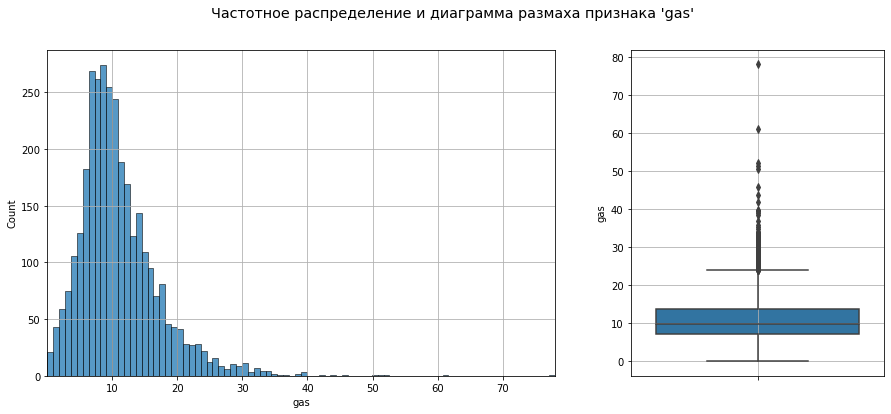

In [29]:
# визуализация распределения пропущенного объема газа
draw_distribution(data_gas, 'gas', 'gas')
data_gas['gas'].describe()

Распределение объема пропущенного газа имеет **нормальный** вид. Медианное значение равно 9.8. Межквартильный размах находится в диапазоне от 7.0 до 13.8. Выбросы есть, но они располагаются достаточно близко к основной группе точек.

### Данные об объеме сыпучих материалов

Все рассмотренные выше признаки относятся к конкретной партии, время как признак нам интересно не было. Поэтому, рассматривая данные о сыпучих материалах, мы обратимся только к их объемам, то есть к таблице `datum['data_bulk']`.

Как мы отметили выше, в данных много пропусков. Посчитаем количество ненулевых значений для каждого из признаков.

In [30]:
# копирование таблицы
data_bulk = datum['data_bulk']
data_bulk.columns = ['_'.join(col.lower().split()) for col in data_bulk.columns]
del datum['data_bulk']
del datum['data_bulk_time']

In [31]:
# подсчет количества ненулевых значений
data_bulk.count()

key        3129
bulk_1      252
bulk_2       22
bulk_3     1298
bulk_4     1014
bulk_5       77
bulk_6      576
bulk_7       25
bulk_8        1
bulk_9       19
bulk_10     176
bulk_11     177
bulk_12    2450
bulk_13      18
bulk_14    2806
bulk_15    2248
dtype: int64

Мы видим, что чаще всего сыпучие материалы добавляли из бункеров 3, 4, 6, 12, 14 и 15. Рассмотрим распределения признаков, исключая нулевые значения.

Attempting to set identical left == right == 49.0 results in singular transformations; automatically expanding.


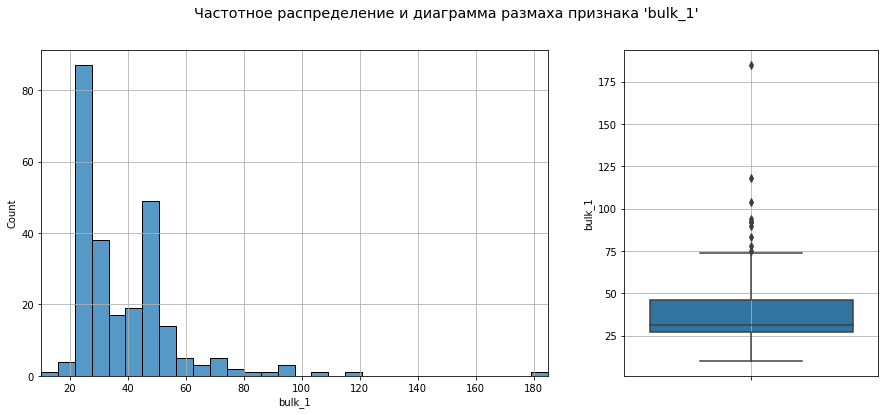

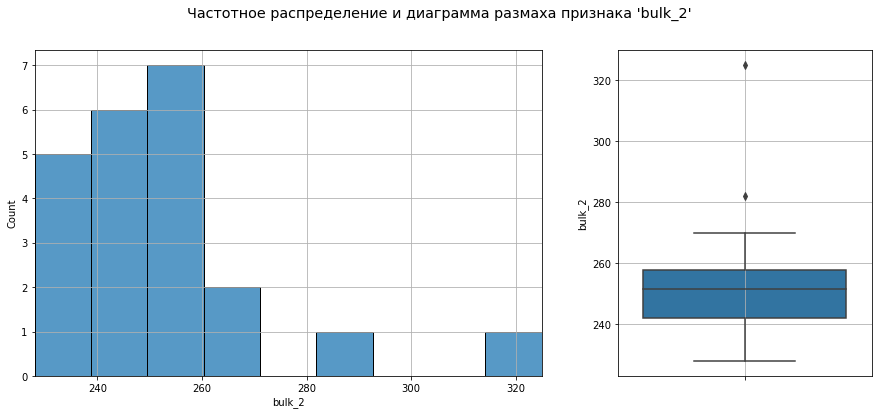

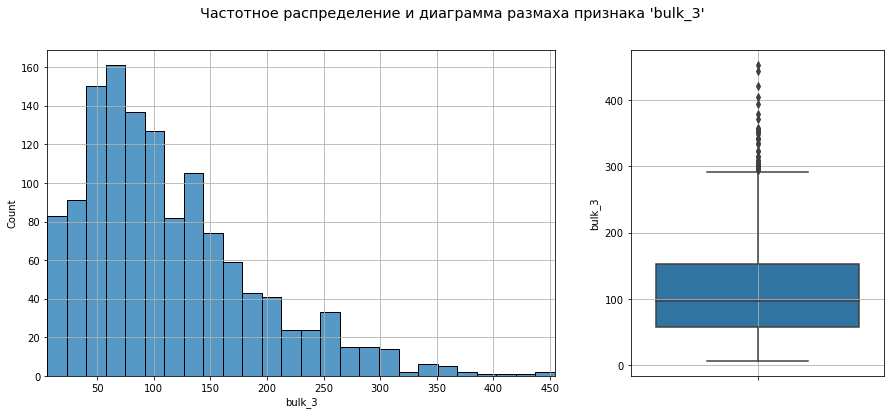

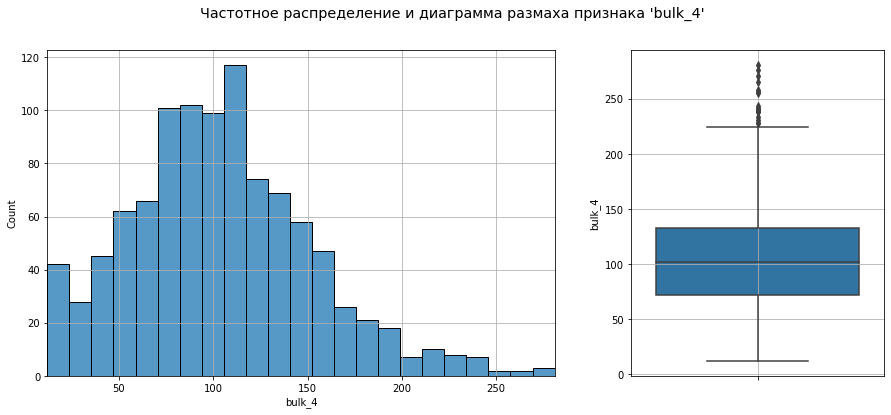

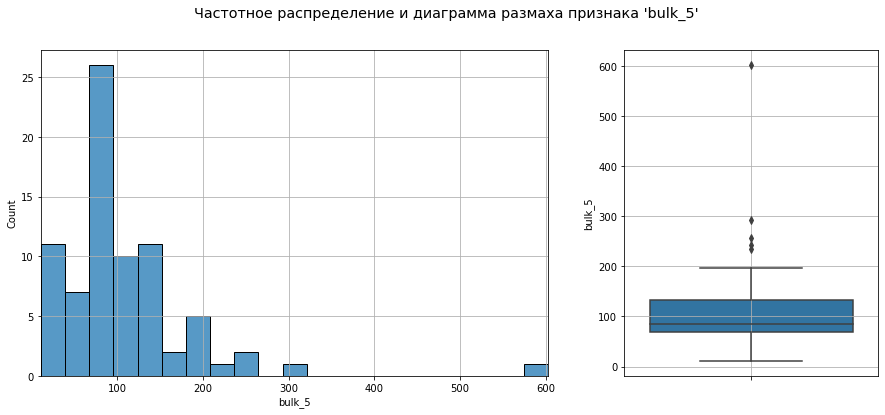

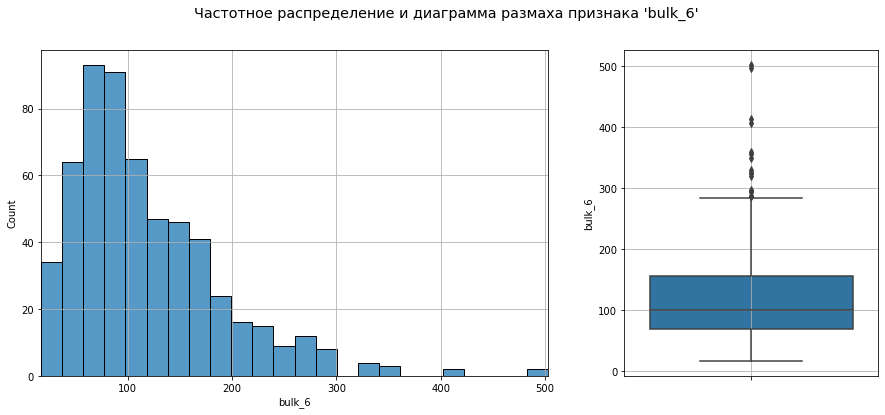

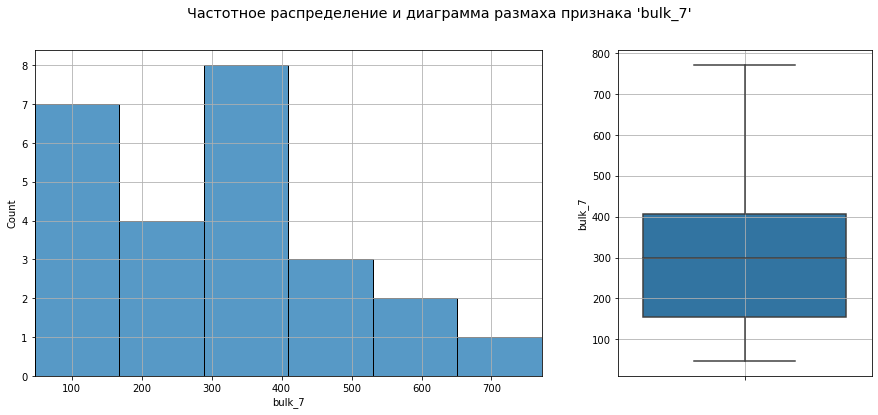

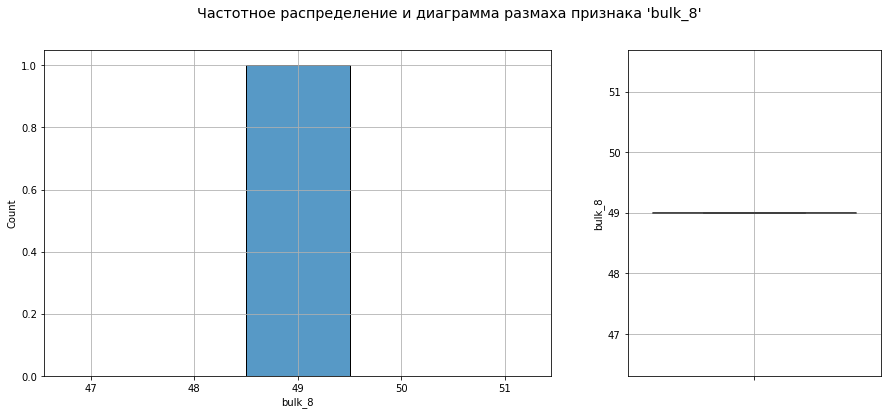

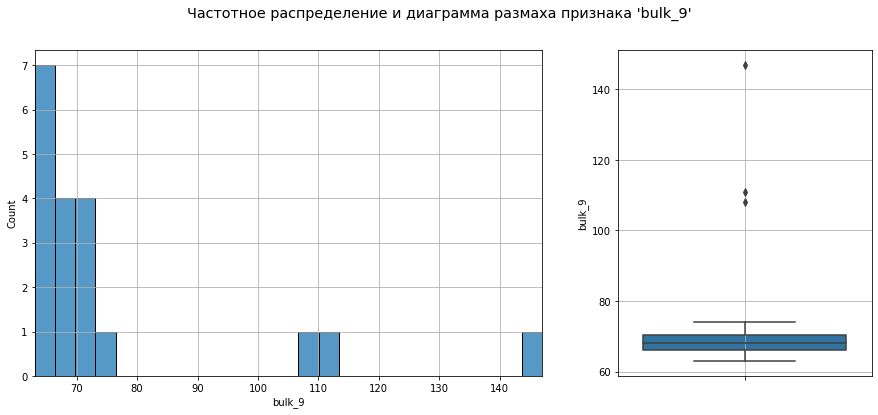

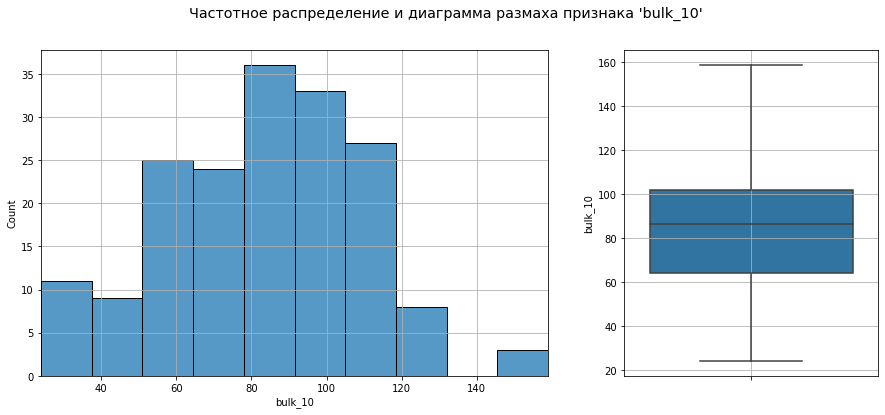

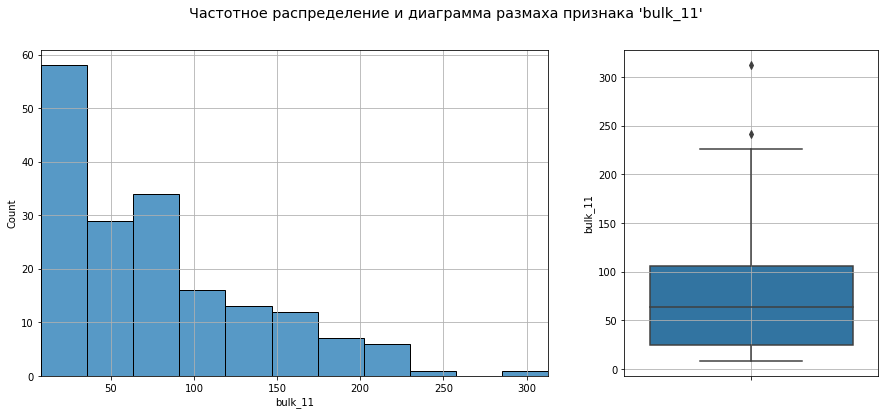

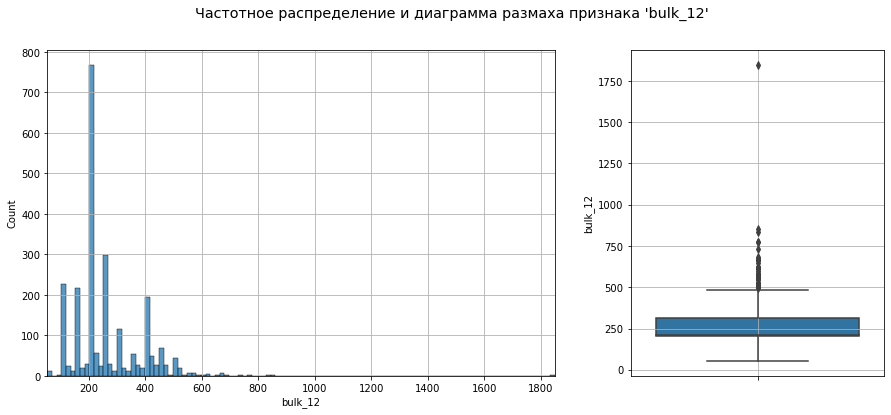

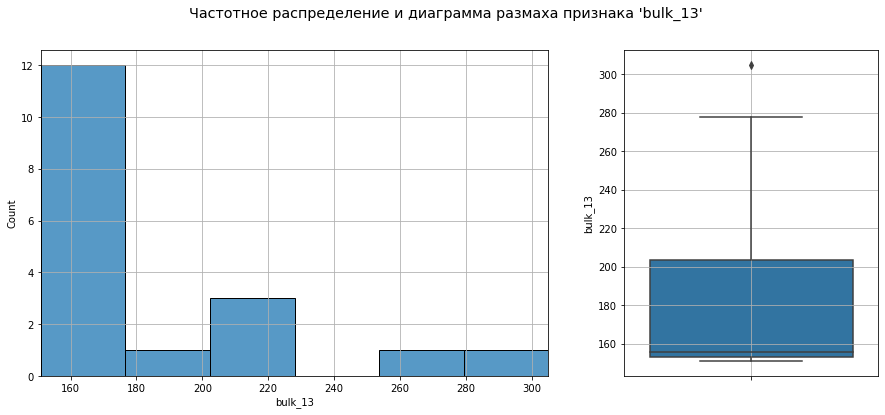

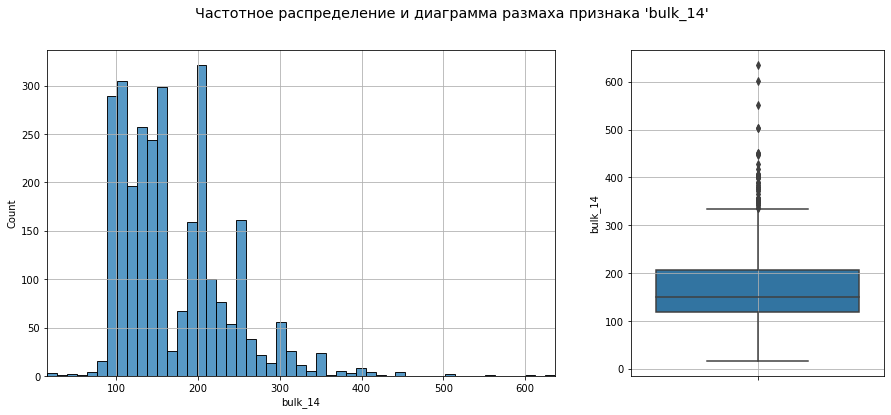

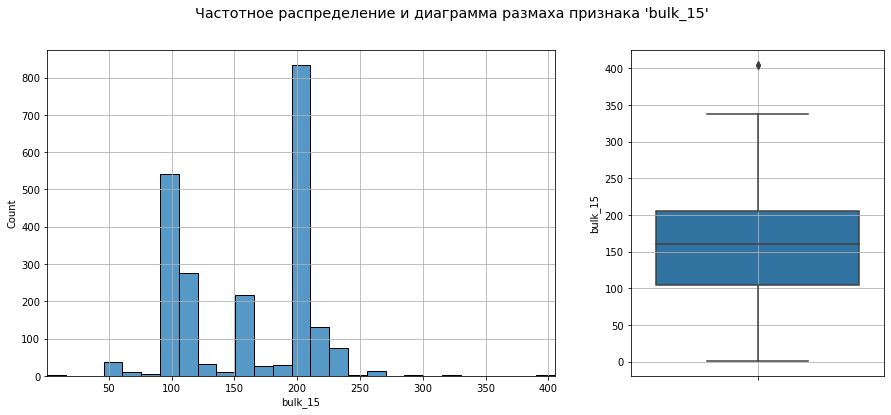

In [32]:
# визуализация распределения объема сыпучих материалов
for bulk in data_bulk.drop(columns='key').columns:
    draw_distribution(data_bulk, bulk, bulk)
    data_bulk[bulk].describe()

Как мы видим, **нормальное** или близкое к нему распределение имеют признаки `bulk_3`, `bulk_4`, `bulk_6` и `bulk_10`. Остальные признаки либо отличаются крайне малым количеством точек, либо обладают явными **модами**, которые хорошо видно у признаков `bulk_1`, `bulk_12`, `bulk_14` и `bulk_15`. Отметим, что существование **мод** может быть вызвано технологическими особенностями обработки сплава или характеристиками самих бункеров.

Заменим все пропуски в данных нулями.

In [33]:
# заполнение пропусков нулями
data_bulk = data_bulk.fillna(0)

### Данные об объеме проволочных материалов

Аналогично прошлому пункту, мы рассмотрим только одну таблицу, связанную с объемами проволочных материалов — `datum['data_wire']`. Выведем количество ненулевых значений для каждого из признаков. Визуализируем распределения признаков, исключая нулевые значения.

In [34]:
# копирование таблицы
data_wire = datum['data_wire']
data_wire.columns = ['_'.join(col.lower().split()) for col in data_wire.columns]
del datum['data_wire']
del datum['data_wire_time']

In [35]:
# подсчет количества ненулевых значений
data_wire.count()

key       3081
wire_1    3055
wire_2    1079
wire_3      63
wire_4      14
wire_5       1
wire_6      73
wire_7      11
wire_8      19
wire_9      29
dtype: int64

Attempting to set identical left == right == 15.132 results in singular transformations; automatically expanding.


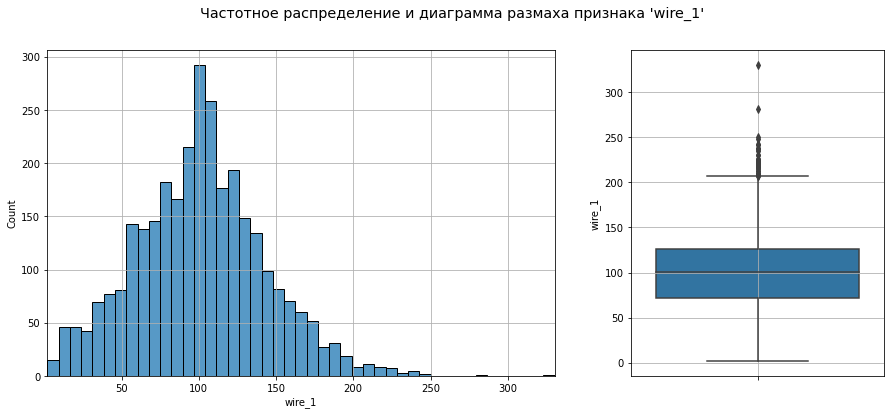

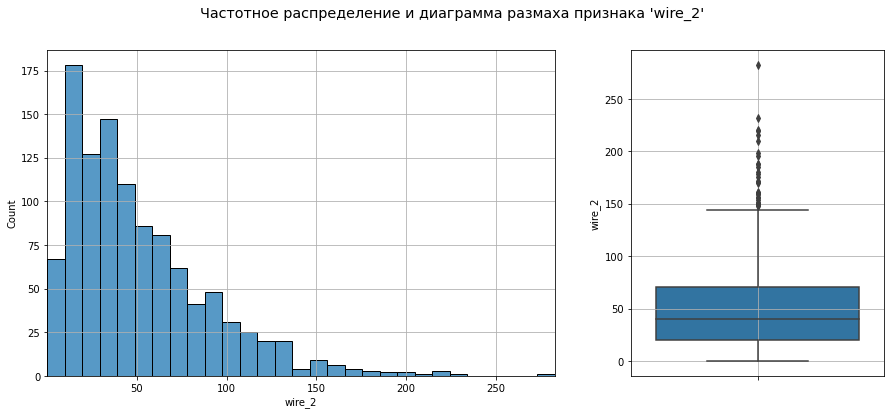

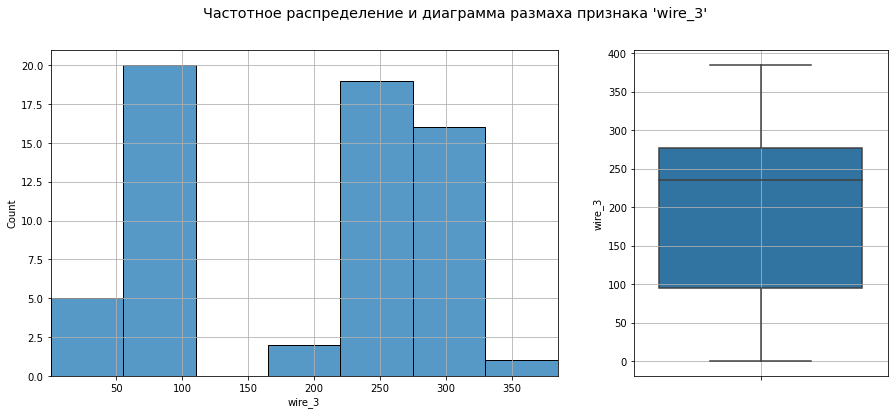

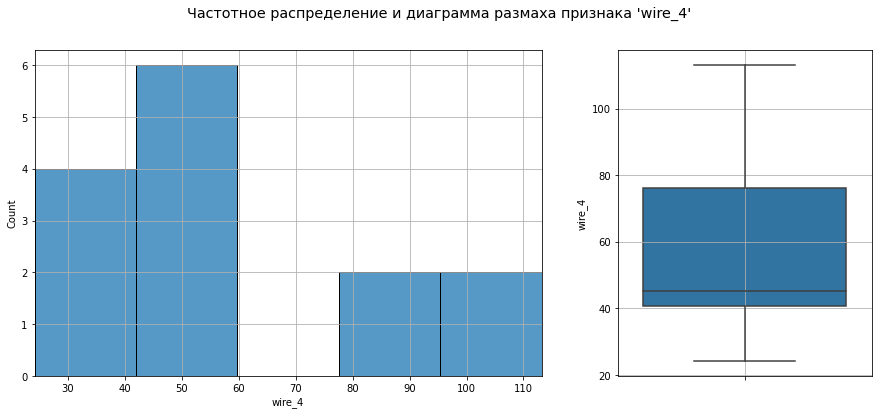

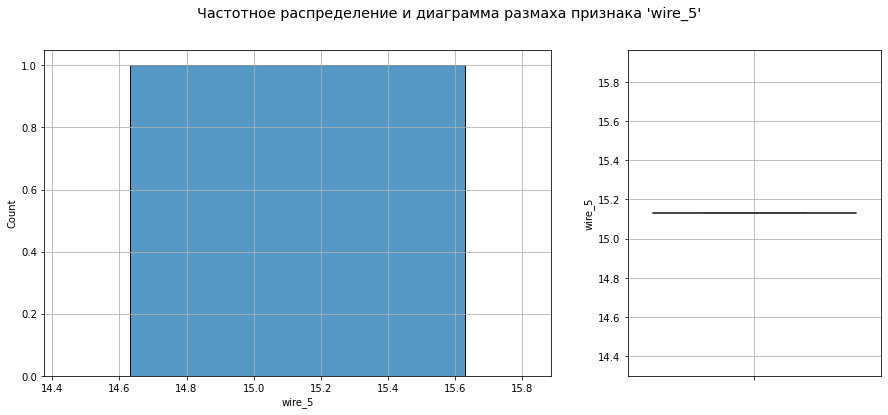

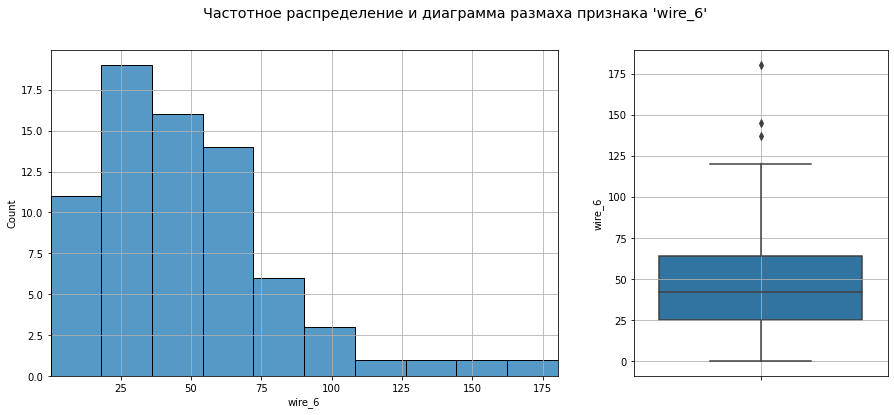

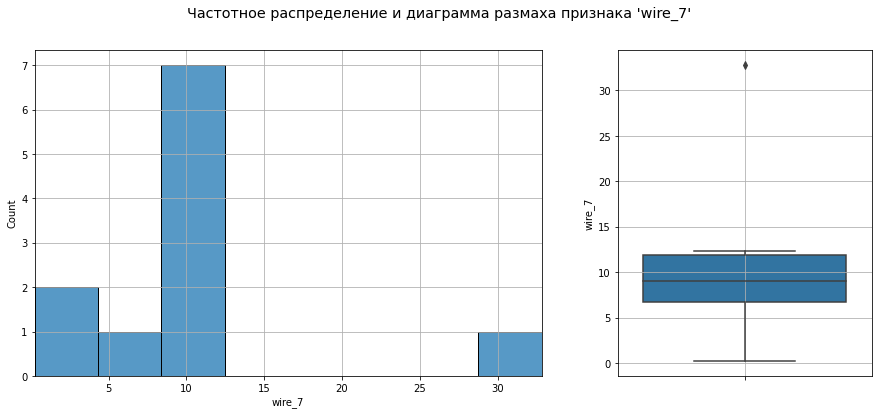

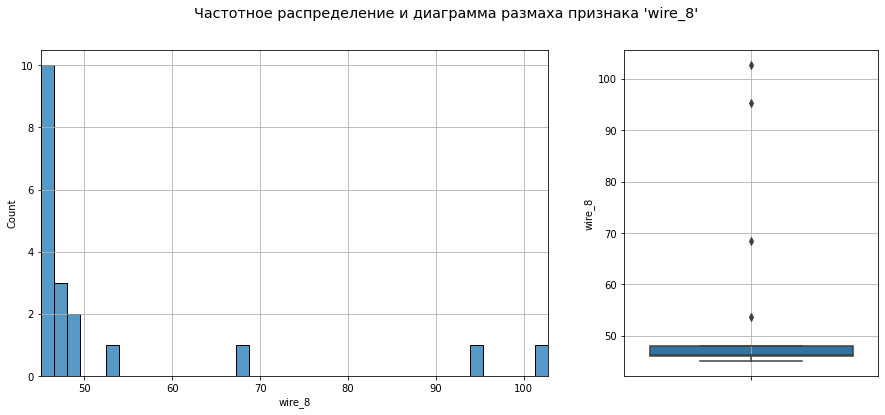

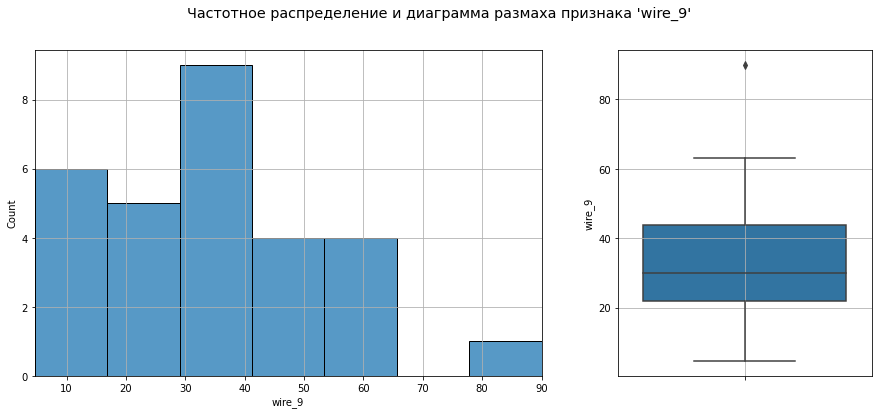

In [36]:
# визуализация распределения объема проволочных материалов
for wire in data_wire.drop(columns='key').columns:
    draw_distribution(data_wire, wire, wire)
    data_wire[wire].describe()

Мы видим, что чаще всего в сплав добавлялись проволоки `wire_1` и `wire_2`. Данные признаки близки к **нормальному** распределению. Про распредления остальных признаков из-за малого количества точек трудно сказать что-то определенное. Выбросы присутствуют, но они расположены достаточно близко к оcновной группе точек. Оставим их для обучения моделей. 

Заполним пропуски в данных нулями.

In [37]:
# заполнение пропусков нулями
data_wire = data_wire.fillna(0)

### Выводы.

Мы исследовали наиболее подходящие для обучения признаки и *целевой признак*. Как оказалось, многие из них имеют **нормальное** распределение. Исключением являются некоторые признаки, связанные с объемами сыпучих и проволочных материалов. Чтобы исследовать признаки на коллинеарность далее воспользуемся **корреляцией Спирмена**.

От части исходных данных пришлось отказаться. Основная потеря связана с тем, что у **23%** партий не оказалось *целевого признака*, а именно конечной температуры сплава. Отсеивание некоторых партий произошло по физическим причинам, как например, начальная температура сплава ниже температуры плавления.
Для всех признаков, которые будут учавствовать в обучении моделей мы провели первичную обработку и привели все данные к нужным типам.

Дальнешая работа будет проходить в несколько **этапов**:

1. Сведение признаков в единую таблицу.
2. Проведение корреляционного анализа признаков.
3. Разделение данных на *обучающую* и *тестовую выборки*. Стандартизация *обучающих признаков*.
4. Обучение моделей *гребневой регрессии*, *случайного леса* и *градиентного бустинга*.
5. Выбор наилучшей модели и ее тестирование.
6. Определение наиболее значимих признаков.
7. Подведение итогов.

## Разделение на обучающую и тестовую выборки

### Создание таблицы с признаками

Мы рассмотрели все исходные таблицы и выделили среди них наиболее значимые признаки. Теперь объединим их в одну таблицу `data`

In [38]:
# объединение таблиц с признаками
data = (data_temp.merge(data_arc, on='key').
        merge(data_gas, on='key').
        merge(data_bulk, on='key').
        merge(data_wire, on='key').
        drop(columns='key'))

In [39]:
# вывод процента потерянных данных
print('{:.0%}'.format(1 - data.shape[0] / origin_size))

6%


Мы объединили данные таким образом, что партии, отсутствующие в какой-либо из таблиц, не попали в новую. Мы избавили себя от необходимости заменять пропуски статистическими показателями выборок. К тому же так мы будем уверены в качестве данных. Доля данных, которую мы потеряли с момента выделения *целевого признака*, составила всего **6%**.

### Проверка признаков на коллинеарность

Как мы отметили ранее, значительная часть признаков имеет **нормальное** или близкое к нему распределение. Распределения некоторых частых признаков, таких как `bulk_1`, `bulk_12`, `bulk_14`, `bulk_15`, подчинены другим законам и имеют **моды**. Чтобы проверить признаки на коллинеарность, воспользуемся **корреляцией Спирмена**.

Text(0.5, 1.0, 'Корреляция признаков')

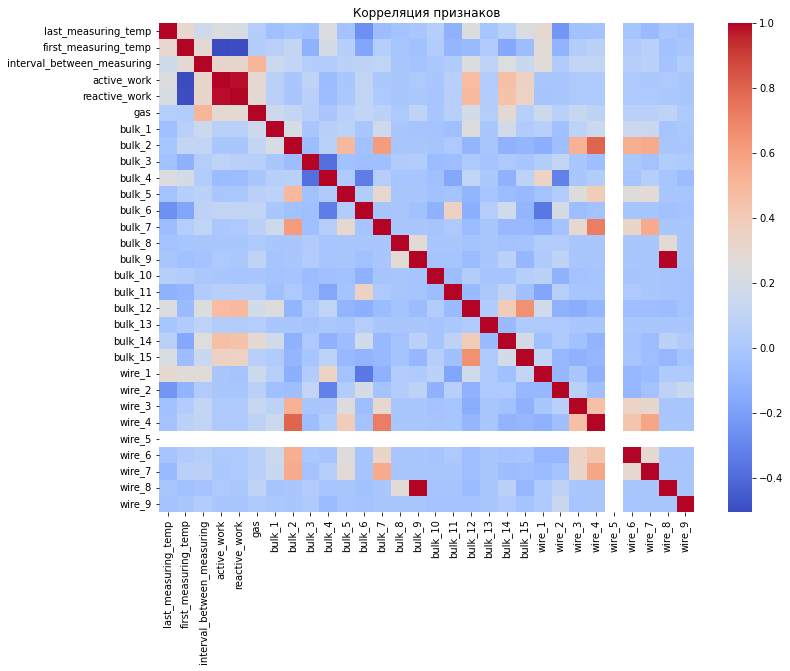

In [40]:
# полная проверка на коллинеарность признаков
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(data.corr(method='spearman'), cmap='coolwarm', ax=ax)
ax.set_title('Корреляция признаков')

Text(0.5, 1.0, 'Корреляция признаков')

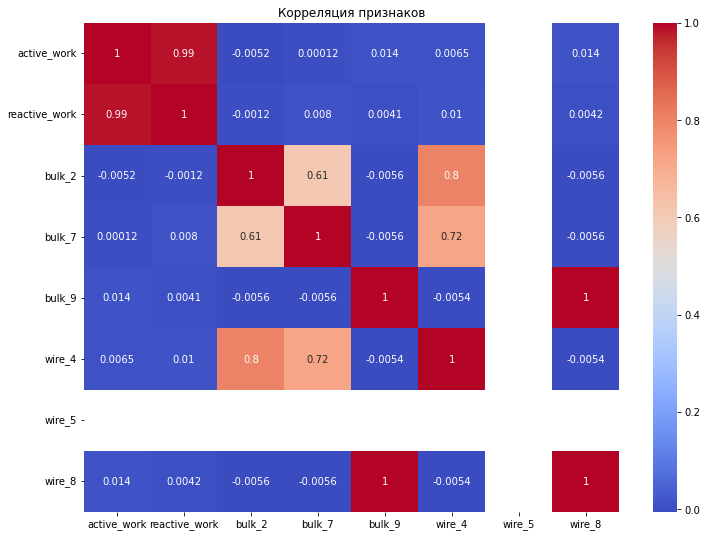

In [41]:
# подробная проверка на коллинеарность признаков
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(data[['active_work', 'reactive_work', 'bulk_2', 'bulk_7', 'bulk_9', 'wire_4',
                  'wire_5', 'wire_8']].corr(method='spearman'), annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Корреляция признаков')

Мы видим, что коллинеарны между собой несколько пар признаков. Как мы предположили ранее, сильная корреляция наблюдается между признаками `active_work` и `reactive_work`. Это является следствием того, что отношение активной и реактивной мощностей не должно меняться от партии к партии. Оно в большей степени связано с электрической схемой нагрева.
Коллинеарны также признаки `wire_8` и `bulk_9`. Признак `wire_5` после объединения всех таблиц теперь стал иметь одни лишь нулевые значения.

Удалим признаки `reactive_work`, `wire_5` и `wire_8`. Повторно визуализируем матрицу корреляции признаков.

In [42]:
# удаление коллинеарного признака
data = data.drop(columns=['reactive_work', 'wire_5', 'wire_8'])

Text(0.5, 1.0, 'Корреляция признаков')

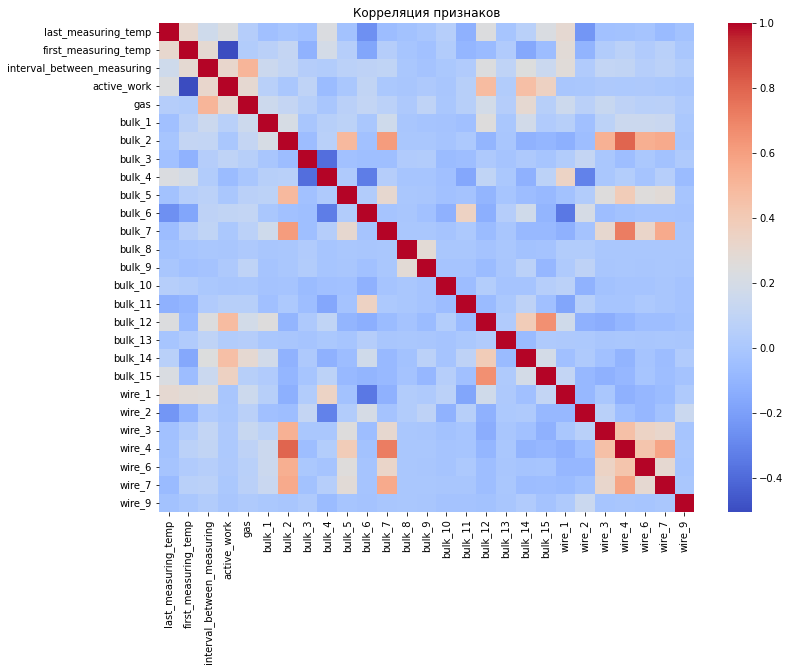

In [43]:
# повторая проверка на коллинеарность признаков
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(data.corr(method='spearman'), cmap='coolwarm', ax=ax)
ax.set_title('Корреляция признаков')

Теперь сильной корреляции между признаками не наблюдается. Выведем первые пять строк итоговой таблицы с признаками. Выведем общую информацию.

In [44]:
# вывод первых пяти строк таблицы
data.head()

,last_measuring_temp,first_measuring_temp,interval_between_measuring,active_work,gas,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_9
0,1613.0,1571.0,14.350000,20.130071,29.749986,0.0,0.0,0.0,43.0,0.0,...,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0
1,1602.0,1581.0,21.750000,12.230275,12.555561,0.0,0.0,0.0,73.0,0.0,...,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0
2,1599.0,1596.0,21.666667,7.393055,28.554793,0.0,0.0,0.0,34.0,0.0,...,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0
3,1625.0,1601.0,6.466667,11.177722,18.841219,0.0,0.0,0.0,81.0,0.0,...,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0
4,1602.0,1576.0,12.700000,16.624935,5.413692,0.0,0.0,0.0,78.0,0.0,...,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0


In [45]:
# вывод общей информации о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   last_measuring_temp         2324 non-null   float64
 1   first_measuring_temp        2324 non-null   float64
 2   interval_between_measuring  2324 non-null   float64
 3   active_work                 2324 non-null   float64
 4   gas                         2324 non-null   float64
 5   bulk_1                      2324 non-null   float64
 6   bulk_2                      2324 non-null   float64
 7   bulk_3                      2324 non-null   float64
 8   bulk_4                      2324 non-null   float64
 9   bulk_5                      2324 non-null   float64
 10  bulk_6                      2324 non-null   float64
 11  bulk_7                      2324 non-null   float64
 12  bulk_8                      2324 non-null   float64
 13  bulk_9                      2324 

С данными все в порядке. Перейдем к формированию *обучающей* и *тестовой выборок*.

### Разделение данных на выборки. Стандартизация признаков.

Поиск наилучшей модели мы будем проводить с помощью кросс-валидации. Поэтому нам понадобятся только *обучающая* и *тестовая выборки*. Выделим *целевой* и *обучающие признаки*. Разделим данные на *обучащую* и *тестовую выборки* в отношении **3:1**.

In [46]:
# выделение признаков
features = data.drop(columns=['last_measuring_temp'])
target = data['last_measuring_temp']

In [47]:
# разделение данных на выборки
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.25, random_state=3102022)

Стандартизируем признаки.

In [48]:
# стандартизация признаков
scaler = StandardScaler()

scaler.fit(train_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

## Построение и обучение моделей

Как упомяналось ранее, мы обучим три типа моделей: *гребневую регрсессию*, *случайный лес* и *градиентный бустинг*. Количество фолдов кросс-валидации `cv` зададим равным **5**, параметр `random_state` положим равным **3102022**. Начнем с модели *гребневой регрсессии*.

### Гребневая регрессия

Обучим модель *гребневой регрессии*. Проведем *кросс-валидационный поиск* модели с помощью класса `GridSearchCV`. Поиск будем проводить по параметру регуляризации `alpha` в пределах `np.arange(1, 16, 1)`. 

In [49]:
%%time
# обучение модели гребневой регрессии
alpha_array = np.arange(1, 16, 1)

param_grid = {'alpha': alpha_array}

ridge_regression = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=2)
ridge_regression.fit(train_features, train_target)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: total: 125 ms
Wall time: 3.56 s


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])},
             scoring='neg_mean_absolute_error', verbose=2)

Визулизируем процесс обучения. Построим график, где по оси абсцисс будет лежать параметр `aplha`, а по оси ординат —  *целевая метрика* *MAE*. Отметим уровень наилучшего достигнутого значения метрики.

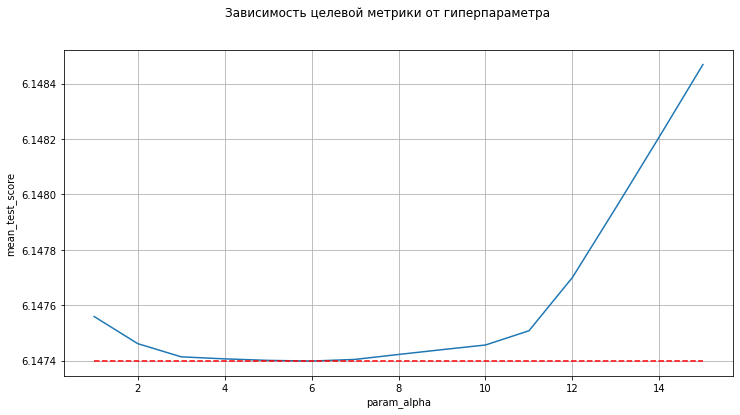

In [50]:
# визуализация процесса обучения
results = pd.DataFrame(ridge_regression.cv_results_)
results['mean_test_score'] = -results['mean_test_score']
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('Зависимость целевой метрики от гиперпараметра')
sns.lineplot(data=results, x='param_alpha', y='mean_test_score', palette='deep', ax=ax)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.hlines(-ridge_regression.best_score_, alpha_array[0], alpha_array[-1], colors='red', linestyles='dashed')
ax.grid()

Как мы видим, зависимость *MAE* от *параметра регуляризации* имеет явный минимум. Он наблюдается в диапазоне значений `alpha` от **4** до **7**. Однако масштаб изменений в рассматриваемом диапазоне небольшой, изменения *целевой метрики* происходят лишь в 3-м знаке.

### Случайный лес

Теперь обучим модель *слуйчаного леса*. Изменяемыми параметрами будут: `criterion`, `n_estimators` и `max_depth`. Диапазоны значений будут следующими:

* `criterion`: `['mae', 'mse']`
* `n_estimators`: `np.arange(5, 26, 1)`
* `max_depth`: `np.arange(5, 21, 1)`

In [51]:
%%time
# обучение моделей случайного леса
criterion_array = ['mae', 'mse']
n_estimator_array = np.arange(5, 26, 1)
max_depth_array = np.arange(5, 21, 1)
param_grid  = {'criterion': criterion_array, 'n_estimators': n_estimator_array, 'max_depth': max_depth_array}
random_forest = GridSearchCV(RandomForestRegressor(random_state=3102022), param_grid,
                             scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, verbose=2)
random_forest.fit(train_features, train_target)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits
CPU times: total: 6.41 s
Wall time: 3min 37s


Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=3102022),
             n_jobs=-1,
             param_grid={'criterion': ['mae', 'mse'],
                         'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                         'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25])},
             scoring='neg_mean_absolute_error', verbose=2)

Визулизируем процесс обучения. Построим два графика, где по оси абсцисс будет лежать параметр `max_depth`, а по оси ординат — *целевая метрика* *MAE*. Разные цвета будут соответствовать разным значениям параметра `n_estimators`. Для первого графика `criterion` будет равен `'mae'`, а для второго — `'mse'`. Отметим уровень наилучшего достигнутого значения метрики.

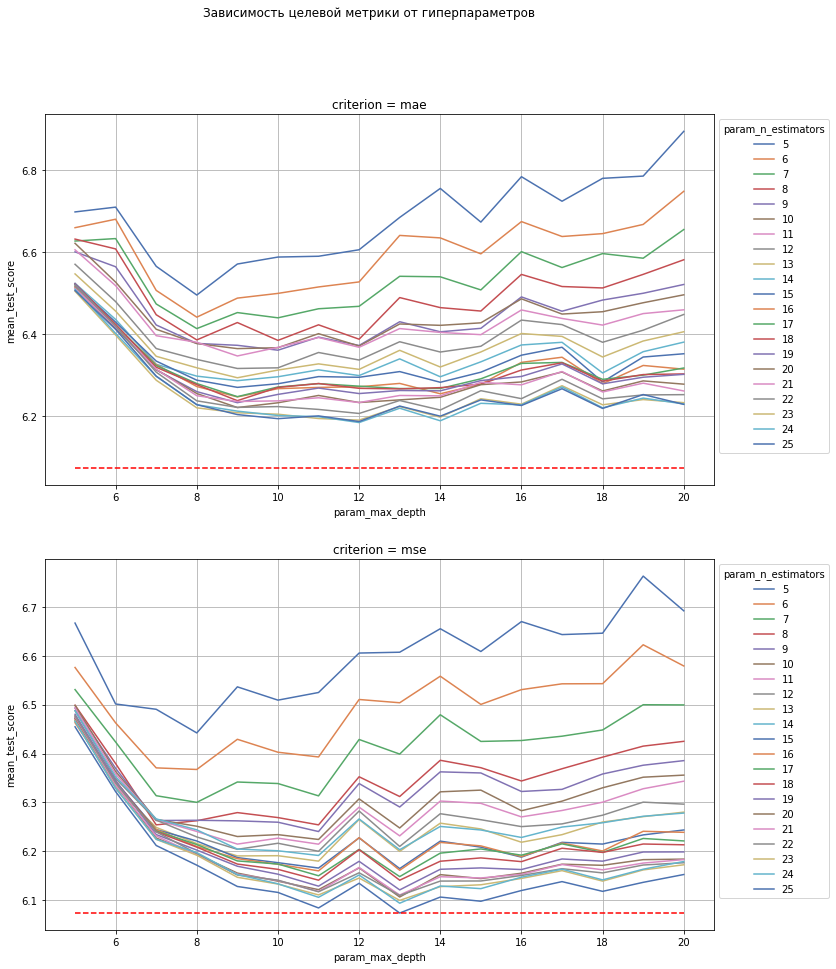

In [52]:
# визуализация процесса обучения
criterion_array = ['mae', 'mse']
n_estimator_array = np.arange(5, 26, 1)
max_depth_array = np.arange(5, 21, 1)
results = pd.DataFrame(random_forest.cv_results_)
results['mean_test_score'] = -results['mean_test_score']
fig, axs = plt.subplots(2, 1, figsize=(12, 15))
fig.suptitle('Зависимость целевой метрики от гиперпараметров')
for i, criterion in enumerate(criterion_array):
    sns.lineplot(data=results.query('param_criterion == @criterion'), x='param_max_depth', y='mean_test_score',
                 hue='param_n_estimators', palette='deep', ax=axs[i])
    axs[i].hlines(-random_forest.best_score_, max_depth_array[0], max_depth_array[-1], colors='red', linestyles='dashed')
    axs[i].legend(title='param_n_estimators', loc='best', bbox_to_anchor=(1, 1))
    axs[i].set_title(f'criterion = {criterion}')
    axs[i].grid()

Мы видим, что зависимость *MAE* от глубины *решающих дереьвев* имеет вначале резкий cпад. Затем либо данная зависимость выходит на насыщение, либо наблюдается постепенное увеличение *целевой метрики*. Увеличение количества *решающих деревеьев* вначале также приводит к улучшению качества моделей. При этом в случае  `criterion` равным `mae` при большом количестве *решающих деревеьев* *целевая метрика* перестает меняться. В случае же с `mse` с ростом количества *решающих деревеьев* *целевая метрика* продолжает уменьшаться.

### Градиентный бустинг

Перейдем к ансамблю *решающих деревьев*, обучаемых методом *градиентного бустинга*. Изменяемыми параметрами будут: `learning_rate`, `depth` и `loss_function`. Диапазоны значений будут следующими:

* `learning_rate`: `np.arange(0.01, 0.10, 0.001)`
* `depth`: `np.arange(2, 6)`
* `loss_function`: `['MAE', 'RMSE']`

Количество итераций `iterations` зададим равным **1000**.

In [53]:
%%time
# обучение градиентным бустингом
learning_rate_array = np.arange(0.01, 0.10, 0.001)
depth_array = np.arange(2, 6)
loss_function_array = ['MAE', 'RMSE']

param_grid = {'learning_rate': learning_rate_array, 'depth': depth_array, 'loss_function': loss_function_array}

gradient_boosting = GridSearchCV(CatBoostRegressor(iterations=1000, random_seed=3102022, verbose=False),
                                 param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5,  verbose=2)
gradient_boosting.fit(train_features, train_target)

Fitting 5 folds for each of 728 candidates, totalling 3640 fits
CPU times: total: 10.1 s
Wall time: 23min 39s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000015A402934C0>,
             n_jobs=-1,
             param_grid={'depth': array([2, 3, 4, 5]),
                         'learning_rate': array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.04...
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ]),
                         'loss_function': ['MAE', 'RMSE']},
             scor

Визуализруем процесс обучения. Построим два графика, где по оси абсцисс будет лежать параметр `depth`, а по оси ординат —  *целевая метрика* *MAE*. Разные цвета будут соответствовать разным значениям параметра `learning_rate`. Для первого графика `loss_function` будет равен `'MAE'`, а для второго — `'RMSE'`. Отметим уровень наилучшего достигнутого значения метрики.

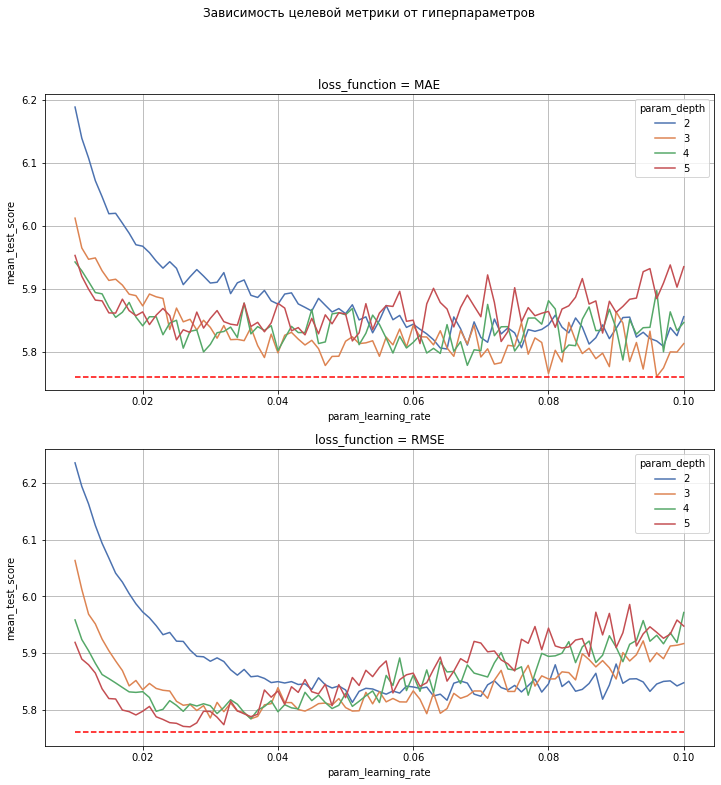

In [54]:
# визуализация процесса обучения
results = pd.DataFrame(gradient_boosting.cv_results_)
results['mean_test_score'] = -1 * results['mean_test_score']
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Зависимость целевой метрики от гиперпараметров')
for i, loss_function in enumerate(loss_function_array):
    sns.lineplot(data=results.query('param_loss_function == @loss_function'), x='param_learning_rate', y='mean_test_score',
                 hue='param_depth', palette='deep', ax=axs[i])
    axs[i].hlines(-gradient_boosting.best_score_, learning_rate_array[0], learning_rate_array[-1], colors='red', linestyles='dashed')
    axs[i].set_title(f'loss_function = {loss_function}')
    axs[i].grid()

В случае, когда *функцией потерь* является `MAE`, качество моделей, начиная с `learning_rate` равной **0.03**, практически не меняется. В случае же с `RMSE` мы можем наблюдать пологий максимум. После `learning_rate` равной **0.04**, *целевая метрика* начинает расти. Визуально наилучший результат показал ансамбль *решающих деревьев* c *глубиной* равной **3**.

## Выбор и тестирование лучшей модели

### Сравнение моделей

Выведем сводную таблицу с параметрами и метриками качества наилучших моделей каждого типа.

In [55]:
# вывод сводной таблицы
mae_array = [abs(round(ridge_regression.best_score_, 2)), abs(round(random_forest.best_score_, 2)),
             abs(round(gradient_boosting.best_score_, 2))]
criterion_array = ['', random_forest.best_params_['criterion'].upper(), gradient_boosting.best_params_['loss_function']]
max_depth_array = ['', random_forest.best_params_['max_depth'], gradient_boosting.best_params_['depth']]
n_estimators_array = ['', random_forest.best_params_['n_estimators'], '']
learning_rate_array = ['', '', gradient_boosting.best_params_['learning_rate']]


table = {'MAE': mae_array, 'criterion/loss_functions': criterion_array, 'max_depth/depth': max_depth_array,
         'n_estimators': n_estimators_array, 'learning_rate': learning_rate_array}
pd.DataFrame(data=table, index=['ridge regression', 'random forest', 'gradient boosting'])

,MAE,criterion/loss_functions,max_depth/depth,n_estimators,learning_rate
ridge regression,6.15,,,,
random forest,6.07,MSE,13,25,
gradient boosting,5.76,MAE,3,,0.096


Как мы видим, ансамбль *решающих деревьев*, обученных методом *градиентного бустинга*, показал лучшие результаты по сравнению с двумя другими моделями. *Градиентный бустинг* позволил достичь на *обучающей выборке* *MAE* равной **5.76**. Модели *гребневой регрессии* и *случайного леса* показали результаты **6.15** и **6.07** соответственно.

### Тестирование лучшей модели

Сравнение моделей показало, что **лучшей** моделью является модель **градиентного бустинга**. Рассчитаем *целевую метрику* для данной модели на *тестовой выборке*.

In [56]:
# вывод MAE для модели градиентного бустинга
df_table = pd.DataFrame(data={'MAE': mean_absolute_error(test_target, gradient_boosting.best_estimator_.predict(test_features))},
                        index=['gradient boosting'])

df_table.index.name = 'model'

df_table

,MAE
model,
gradient boosting,5.734097


На *тестовой выборке* выбранная  модель показала *MAE* равную **5.73**.

### Выявление значимости признаков

Проверим значимость признаков для модели *градиентного бустинга* с помощью библиотеки `shap`. Рассчитаем *значения Шепли*. Построим гистограмму значимости 10 наиболее важных признаков.

In [57]:
# расчет значений Шепли для каждого из признаков
explainer = shap.TreeExplainer(gradient_boosting.best_estimator_)
shap_values = explainer.shap_values(features)

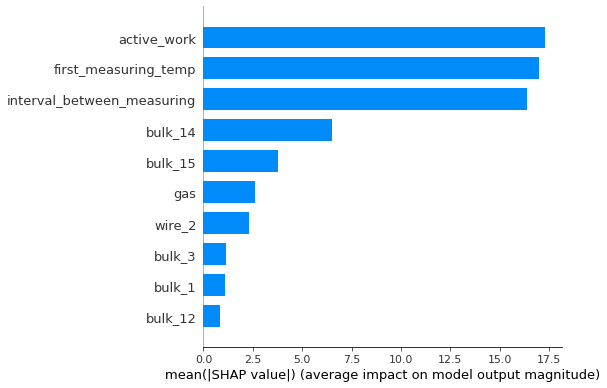

In [58]:
# построение гистрограммы значимости признаков
shap.summary_plot(shap_values, features, max_display=10, plot_type='bar')

Вполне обоснованным с физической точки зрения кажется то факт, что наибольший вклад в качество модели внесла информация о начальной температуре сплава `first_measuring_temp`, информация о работе, затраченной на его нагрев, `active_work` и информация о промежутке времени между измерениями начальной и конечной температур `interval_between_measuring`.
Другими значимыми признаками, также вошедшими в топ-10 оказались `bulk_14`, `bulk_15`, `gas`, `wire_2`, `bulk_3`, `bulk_1` и `bulk_12`.

## Выводы

Итак, мы решали задачу, связанную с процессом легирования расплавленной стали. Задача заключалась в создании модели, способной предсказывать конечную температуру сплава с точностью *MAE* < **6.8**.

Познакомились с данными, определились с примерным количеством объектов в выборке. Выделили из данных признаки и сформировали пару новых: `interval_between_measuring` и `active_work`. Для каждого из признаков провели исследовательских анализ: построили их распределения и оценили физичность наблюдаемых выборосов. Если выбросы были нефизичны, такие партии удалялись из дальнейшего рассмотрения.

Чтобы сохранить качество данных, мы сформировали итоговую таблицу с признаками таким образом, что в нее попали лишь те партии, в которых отсутствовали пропуски. Итоговая потеря данных, не учитавая тех, что были отброшены из-за отсутствия *целевого признака* (а таких оказалось **23%**), составила всего **6%**. Проверили признаки на *коллинераность*. После чего удалили признаки `reactive_work`, `wire_5` и `wire_8`. Количество *обучающих признаков* оказалось равным **26**. Данные разделили на *обучающую* и *тестовую выборки* в отношении **3:1**. *Обучающую выборку* составило **1743** объеката, *тестовую* — **581**. Стандартизировали признаки.

Далее мы рассмотрели три типа моделей: *гребневую регрсессию*, *случайный лес* и *градиентный бустинг*. С помощью *кросс-валидационного поиска* нашли лучшие модели каждого типа. Рассмотрели зависимости *целевой метрики* от различных *гиперпараметров*. Сравнили модели между собой.

По итогу лучшую *целевую метрику* *MAE* на *обучающей выборке* показал ансамбль **решающих деревьев**, обученных методом **градиентного бустинга**. Его оптимальными параметрами оказались `loss_functions` = `MAE`, `depth` = `3` и `learning_rate` = `0.096`. *MAE*, которое показала модель на *обучающей выборке* оказалось равной **5.76**, на *тестовой* — **5.73**. Такой результат говорит о том, что модель **не переобучилась**. Гистограмма значимости признаков  показала, что наиболее важными из них при обучении модели оказались `active_work`, `first_measuring_temp` и `interval_between_measuring`.

Итак, нам удалось достигнуть поставленной задачи, выполнив все этапы работы, упомянутые в конце исследовательского анализа. Мы сумели построить модель, *целевая метрика* которой на *тестовой выборке* оказалась равной **5.73** (требобвалось ниже **6.8**). При этом можно отметить, что модель обучалась на широком диапазоне данных. Мы убрали из рассмотрения лишь те данные, что казались **нефизичными**. 

При работе над уменьшением энергопотребления стоит обратить внимание на то, что наибольший вклад в прогнозирование конечной температуры сплава вносят признаки, которое представляют собой начальную темпертуру сплава `first_measuring_temp`, работу `active_work`, затраченную на его нагрев, и интервал времени между замерами начальной и конечной тепмератур `interval_between_measuring`. Ниже еще раз представим гистограмму значимости признаков.

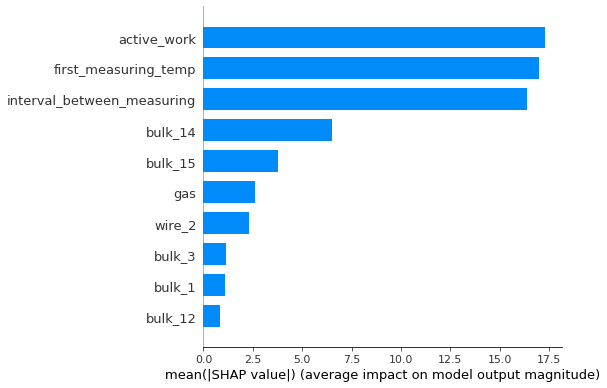

In [59]:
# построение гистрограммы значимости признаков
shap.summary_plot(shap_values, features, max_display=10, plot_type='bar')